# Assignment 2
## ML based image denoising

**Models used**

For cleaning the images, Random Forest Regressor and CNNs have been used. 

CNNs provide a great advantage in extracting spatially correlated features and thus form a popular choice for image-related ML tasks

Random Forests is an ensemble method which combines the predictions from all the decision trees that make up the forest

**Initial Guess on what might work**

Since CNNs were designed to make predictions using spatial information, I expect them to work better over RFR. RFR cannot take a multi-dimensional input and requires the image matrix to be flattened, which might act as a draw back since some spatial information is lost in the process.

As for the choice of w, I believe that there is a small optimal value (might be different for each model) and the MSE would probably increase after increasing w beyond w_opt since, in most cases, this would increase the variance of the intensity values.   

In [1]:
# Importing required packages
from skimage import color
from skimage.util import random_noise
from skimage import filters
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from matplotlib import image
import PIL
import cv2
import os

In [2]:
# collecting the paths for all training, validation and test images
train_images_paths = []   
for root, __, files in os.walk("/content/drive/MyDrive/images/train/"): # selecting images from google drive
  for f in files:
      if f.endswith(".jpg"):  # all images are in jpg format, so finding all files ending with this extension
         train_images_paths.append(os.path.join(root, f))

val_images_paths = []
for root, __, files in os.walk("/content/drive/MyDrive/images/val/"):
  for f in files:
      if f.endswith(".jpg"):
         val_images_paths.append(os.path.join(root, f))

test_images_paths = []
for root, __, files in os.walk("/content/drive/MyDrive/images/test/"):
  for f in files:
      if f.endswith(".jpg"):
         test_images_paths.append(os.path.join(root, f))

In [3]:
# for each list of paths from the previous cell, the following arrays will contain the actual RGB images
# The images are in 0..1 range for ease of training
train_images = [image.imread(train_images_paths[i]).astype('float')/255.0 for i in range(len(train_images_paths))]
val_images = [image.imread(val_images_paths[i]).astype('float')/255.0 for i in range(len(val_images_paths))]
test_images = [image.imread(test_images_paths[i]).astype('float')/255.0 for i in range(len(test_images_paths))]

## Image degradation and helper functions

Noise Models Used: Gaussian, Salt & Pepper, Rayleigh, Poisson, Gamma

Blur Models Used: Gaussian, Mean

### Defining Functions

In [4]:
def hist_equalize(rgb):
  HSV = color.rgb2hsv(rgb) # converting RGB to HSV format
  H,S,V = HSV[:,:,0], HSV[:,:,1], HSV[:,:,2] # separating the H,s and V layers
  # The 'V' layer is scaled from [0 - 255] to [0 - 1], we need to get the appropriate bins back
  V = np.round(V*255) # Scaling the intensity values
  
  bins = [i for i in range(256)] # an array of intensity values 
  counts = [] # to store the counts
  for i in bins:
    counts.append((V==i).sum()) # collecting the count for each instensity level
  
  probs = counts/sum(counts)  # converting to probabilites
  cdf = np.array([probs[:i].sum() for i in range(256)]) # generating the cdf by partial summation
  
  # We now have a map for each pixel
  # The index value is the key and the corresponding array element
  # is the new instensity level for that pixel
  T_r = np.round(cdf*255) 
  
  V_new = np.array([T_r[int(i)] for i in V.flatten()]) # Transforming each pixel to new intensity value
  V_new = V_new.reshape(V.shape) # reshaping the matrix

  HSV_new = np.zeros(HSV.shape) # Forming a new HSV tensor
  HSV_new[:,:,0], HSV_new[:,:,1], HSV_new[:,:,2] = H, S, V_new/255 # Appropriately scaled values before returning
  # new_image = color.hsv2rgb(HSV_new)*255

  # return new_image.astype("uint8")

  return color.hsv2rgb(HSV)


In [5]:
def clip(arr):
  """
    input: array
    output: depending on the max of the array, it is clipped
            appropriately
  """
  if arr.max() <= 4:
    return np.clip(arr, 0, 1) # assuming that overflow won't exceed 4 when required maximum is 1
  else:
    return np.clip(arr, 0, 255) # If range exceeds 4, assuming it must be 8-bit encoded

In [6]:
def add_noise(img, type):
  """
    input: image array
    parameter: type of noise to be added
    output: noisy_image
    Notes:
          - s&p and poisson have been added using the skimage package
          - gaussian, rayleigh and gamma have been modeled here 
  """
  if img.max() >= 5:    # converting images to 0..1 range if that's not the case. Using '5' as the threshold value
    img = img.astype('float')/255.0
    
  if type == "gaussian":
    noisy_img = img + np.random.normal(0, 0.07, size=img.shape) # noise sampled from 0 mean gaussian with sigma = 0.07
  elif type == 's&p':
    noisy_img = random_noise(img, mode='s&p') # adds s&p noise to the image using the skimage package
  elif type == 'poisson':
    noisy_img = random_noise(img, mode='poisson') # adds poisson noise using the skimage package
  elif type == "rayleigh":
    rng = np.random.default_rng()
    noisy_img = img + rng.rayleigh(0.2, img.shape)  # Rayleigh noise with 
  elif type == "gamma":
    noisy_img = img + np.random.gamma(0.9, 0.2, img.shape)

  return clip(noisy_img)

In [7]:
def blur(img, type):
  """
  input: image array
  parameters: 
      - 'type': mean or gaussian
      - 'extent': default 'low', choose from ['low', 'moderate', 'high']
                  for gaussian, it varies the sigma
                  for mean, it varies the size of the kernel
  output: blurred image
  """
  if type == "gaussian":
    blurred = filters.gaussian(img, multichannel=True, sigma=1.2) # resetting the range to 0-255
  elif type == 'mean':
    kernel = np.ones((5,5),np.float32)/5**2
    blurred = cv2.filter2D(img,-1,kernel)
  elif type == 'none':
    blurred = img
  
  return blurred

In [8]:
def degrade_image(img):
  """
  input: image array
  output: randomly degraded image
  """
  blur_model = np.random.choice(['mean', 'gaussian', 'none']) # randomly choosing a blur model 
  noise_model = np.random.choice(['gaussian', 's&p', 'gamma', 'poisson', 'rayleigh'])   # randomly choosing a noise model
  blurred_image = blur(img, blur_model)
  degraded_image = add_noise(blurred_image, noise_model)
  
  return clip(degraded_image)

Degrading the Images to form train and test set

In [9]:
# Training set

train_degraded_images = []  # collecting the degraded images
W = 61 # Patch window size
numPatches = 20 # Number of patches to be extracted from an image
train_clean_patches = []    # collecting clean patches
train_degraded_patches = [] # collecting degraded patches

for _ in range(5):          # corresponding to each clean image, there will be 5 different degraded images
  for img in train_images: 
    degraded_image = degrade_image(img)
    train_degraded_images.append(degraded_image)

    for i in range(numPatches): # For number of patches
      x = np.random.randint(0, img.shape[0]-W+1) # Random x location so that the patch 
                                              # remains within image boundaries
      y = np.random.randint(0, img.shape[1]-W+1) # Random y location
                                              # remains within image boundaries
      train_clean_patches.append(img[x:x+W,y:y+W,:]) # Extract patch
                                              # Divide by 255 for float images
      train_degraded_patches.append(degraded_image[x:x+W,y:y+W,:])

In [10]:
# Validation Set

val_clean_patches = []    # images for validation set
val_degraded_patches = [] # collecting degraded patches
val_degraded_images = []  # collecting degraded images

for img in val_images:                  
  degraded_image = degrade_image(img)   # degrading the image
  val_degraded_images.append(degraded_image)  

  for i in range(numPatches): # For number of patches
    x = np.random.randint(0, img.shape[0]-W+1) # Random x location so that the patch 
                                            # remains within image boundaries
    y = np.random.randint(0, img.shape[1]-W+1) # Random y location
                                            # remains within image boundaries
    val_clean_patches.append(img[x:x+W,y:y+W,:]) # Extract patch
                                            # Divide by 255 for float images
    val_degraded_patches.append(degraded_image[x:x+W,y:y+W,:])

In [11]:
# Test Set

test_clean_patches = [] 
test_degraded_patches = []
test_degraded_images = []

for img in test_images:
  degraded_image = degrade_image(img)
  test_degraded_images.append(degraded_image)

  for i in range(3): # For number of patches
    x = np.random.randint(0, img.shape[0]-W+1) # Random x location so that the patch 
                                            # remains within image boundaries
    y = np.random.randint(0, img.shape[1]-W+1) # Random y location
                                            # remains within image boundaries
    test_clean_patches.append(img[x:x+W,y:y+W,:]) # Extract patch
                                            # Divide by 255 for float images
    test_degraded_patches.append(degraded_image[x:x+W,y:y+W,:])

len(test_degraded_patches) == len(test_clean_patches)

True

## Model No.1: CNN

### Creating training dataset

- Experimented with w = 3, 5, 11, 21 and 31
- w_opt = 5 for CNN

In [12]:
w = 5
y_train = np.array([patch[int((w-1)/2), int((w-1)/2), :] for patch in train_clean_patches])     # Out of extracted patches, selecting the first w x w array
x_train = np.array([patch[:w, :w, :] for patch in train_degraded_patches])                      # Selecting the central pixel for w x w array

y_test = np.array([patch[int((w-1)/2), int((w-1)/2), :] for patch in test_clean_patches])       # Out of extracted patches, selecting the first w x w array
x_test = x_val = np.array([patch[:w, :w, :] for patch in test_degraded_patches])                # Selecting the central pixel for w x w array

In [13]:
y_val = np.array([patch[int((w-1)/2), int((w-1)/2), :] for patch in val_clean_patches])         # Out of extracted patches, selecting the first w x w array
x_val = np.array([patch[:w, :w, :] for patch in val_degraded_patches])                          # Selecting the central pixel for w x w array

### Designing and training the CNN model

Best Design for CNN:
1. 64 neuron Conv2D layer with kernel size = 3X3
2. 64 neuron Conv2D layer with kernel size = 5X5
3. 2X2 Max Pooling
4. 32 neuron Conv2D layer with kernel size = 3X3
5. 32 neuron Conv2D layer with kernel size = 3X3
6. 2X2 Max Pooling
7. 64 neuron Dense layer
8. 64 neuron Dense layer
9. 3 neuron output layer (one for each chanel) Sigmoid 

In [14]:
import tensorflow as tf   # using tensorflow for NN
device_name = tf.test.gpu_device_name()   # using gpu to train the network 
from tensorflow.keras import layers, models 

with tf.device('/device:GPU:0'):
  model = models.Sequential([
    layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(w,w,3)),   # two conv2D layers for feature extraction
    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),                                                          # Max Pooling layers
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),                                            # Dense layers for regression
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='sigmoid')                                           # sigmoid output for pixel values in range 0..1
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError())
  history = model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))  # training for 15 epochs

Epoch 1/15
625/625 [==============================] - 36s 6ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2/15
625/625 [==============================] - 4s 6ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 3/15
625/625 [==============================] - 4s 6ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 4/15
625/625 [==============================] - 4s 6ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 5/15
625/625 [==============================] - 4s 6ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 6/15
625/625 [==============================] - 4s 6ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 7/15
625/625 [=======

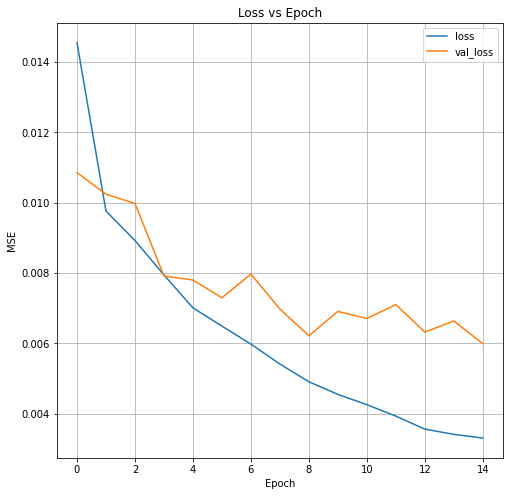

In [15]:
# Displaying the MSE loss for CNN (averaged over the 3 chanels)

plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title("Loss vs Epoch")
plt.show()

Evaluating MSE on test set:

In [16]:
# This gives us the MSE error in terms of intensity-squared
np.array(model.evaluate(x_test, y_test))*255

19/19 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062


array([1.58370301, 1.58370301])

### Prediction and reconstruction function for CNN

In [17]:
def clean_img_CNN(index, w):
  test_output = test_degraded_images[index]   # selecting a test_image
  test_patches = []                           # extracting patches of size w x w x 3
  for i in range(test_output.shape[0]-w+1):   # moving row-wise
    for j in range(test_output.shape[1]-w+1): # moving column-wise
      test_patches.append(test_output[i:i+w, j:j+w, :]) 
  test_patches = np.array(test_patches)       # converting to np array

  with tf.device('/device:GPU:0'):            # utilizing GPU for tensor multiplication
    test_output = model.predict(test_patches).reshape(test_output.shape[0]-w+1, test_output.shape[1]-w+1, 3)    # reshaping the output to (H, W, 3)

  return test_output

In [40]:
from skimage import exposure

## Model No.2: Random Forest Regression

In [18]:
# importing Regressor class and mse metric
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

### Creating the training data set

Experimented with w = 5, 11, 21, 37

For RFR, w_opt = 11

In [19]:
w = 11
y_train = np.array([patch[int((w-1)/2), int((w-1)/2), :] for patch in train_clean_patches])
x_train = np.array([patch[:w, :w, :] for patch in train_degraded_patches])

y_test = np.array([patch[int((w-1)/2), int((w-1)/2), :] for patch in test_clean_patches])
x_test = x_val = np.array([patch[:w, :w, :] for patch in test_degraded_patches])

In [20]:
y_val = np.array([patch[int((w-1)/2), int((w-1)/2), :] for patch in val_clean_patches])
x_val = np.array([patch[:w, :w, :] for patch in val_degraded_patches])

### Training the model

- The model gives best result when the max_depth is left unspecified, so that all trees are trained fully.
- For each tree, the entire data set is used
- The number of features is left as 'auto'
- 3 RFR models have been trained for each chanel, since noise is chanel wise

In [21]:
regr1 = RandomForestRegressor(random_state=0)     # regressor for R
regr2 = RandomForestRegressor(random_state=0)     # regressor for G
regr3 = RandomForestRegressor(random_state=0)     # regressor for B

regr1.fit(x_train[:, :, :, 0].reshape(-1, w**2), y_train[:, 0])   # The chanel arrays are required to be flattened before training 
regr2.fit(x_train[:, :, :, 1].reshape(-1, w**2), y_train[:, 1])   
regr3.fit(x_train[:, :, :, 2].reshape(-1, w**2), y_train[:, 2])

y_pred1 = regr1.predict(x_val[:, :, :, 0].reshape(-1, w**2))      # Predicting the reslukts on val data
y_pred2 = regr2.predict(x_val[:, :, :, 1].reshape(-1, w**2))
y_pred3 = regr3.predict(x_val[:, :, :, 2].reshape(-1, w**2))

print(mse(y_val[:, 0], y_pred1)*255)      # calculating the mse and multiplying with 255
print(mse(y_val[:, 1], y_pred2)*255)      # MSE calculated here is for each chanel 
print(mse(y_val[:, 2], y_pred3)*255)

2.2550329164993665
2.1356213472833807
2.0145060981087997


### Prediction function for RFR

In [22]:
def clean_img_RFR(index, w):
  test_patches = []   # collecting patches
  for i in range(test_degraded_images[index].shape[0]-w+1):
    for j in range(test_degraded_images[index].shape[1]-w+1):
      test_patches.append(test_degraded_images[index][i:i+w, j:j+w, :])
  test_patches = np.array(test_patches)

  # The following three lines predict the clean central pixels and reshape the output to appropriate dimensions (per chanel only)  
  test_pred1 = regr1.predict(test_patches[:, :, :, 0].reshape(-1, w**2)).reshape(test_degraded_images[index].shape[0]-w+1, test_degraded_images[index].shape[1]-w+1)
  test_pred2 = regr2.predict(test_patches[:, :, :, 1].reshape(-1, w**2)).reshape(test_degraded_images[index].shape[0]-w+1, test_degraded_images[index].shape[1]-w+1)
  test_pred3 = regr3.predict(test_patches[:, :, :, 2].reshape(-1, w**2)).reshape(test_degraded_images[index].shape[0]-w+1, test_degraded_images[index].shape[1]-w+1)

  test_output = np.array([test_pred1, test_pred2, test_pred3])    # combining the three chanels and reshaping it to (H, W, 3)
  test_output = np.transpose(test_output, (1, 2,0))

  return test_output

## Results on sample images

In [26]:
# to improve the exposure of the cleaned images
from skimage import exposure

In [24]:
# patch widths for CNN and RFR predictors
w_CNN = 5
w_RFR = 11

[]

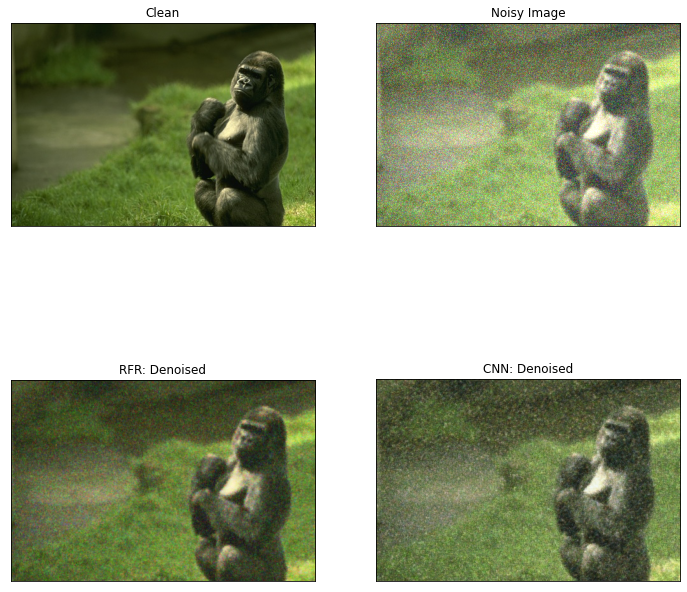

In [40]:
fig = plt.figure(figsize=(12, 12))
index = 44

ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(test_images[index])
ax.set_title('Clean')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(test_degraded_images[index])
ax.set_title('Noisy Image')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 3)
# RFR_cleaned = clean_img_RFR(index, w_RFR)
imgplot = plt.imshow(exposure.adjust_gamma(RFR_cleaned, 1.2))     # gamma adjusted for this image
ax.set_title('RFR: Denoised')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 4)
# CNN_cleaned = clean_img_CNN(index, w_CNN)
imgplot = plt.imshow(exposure.adjust_gamma(CNN_cleaned, 0.8))     # gamma adjusted for this image
ax.set_title('CNN: Denoised')
ax.set_xticks([])
ax.set_yticks([])

[]

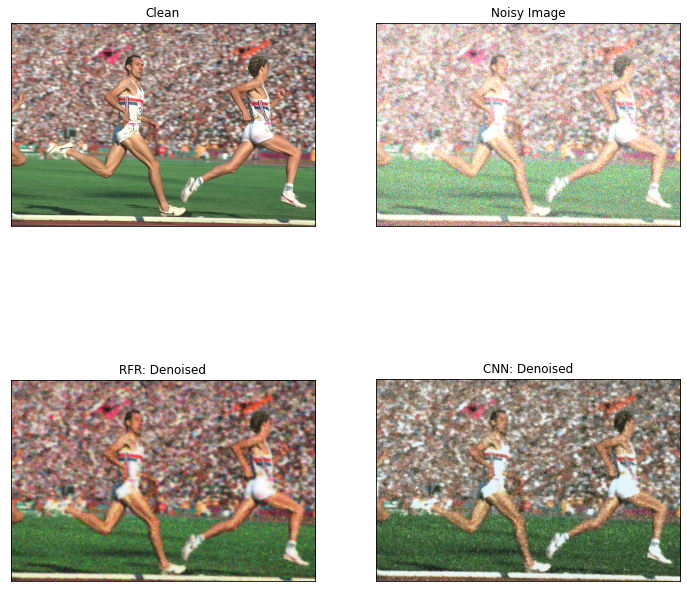

In [35]:
fig = plt.figure(figsize=(12, 12))
index = 33

ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(test_images[index])
ax.set_title('Clean')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(test_degraded_images[index])
ax.set_title('Noisy Image')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 3)
# RFR_cleaned2 = clean_img_RFR(index, w_RFR)
imgplot = plt.imshow(exposure.adjust_gamma(RFR_cleaned2, 1.6))
ax.set_title('RFR: Denoised')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 4)
# CNN_cleaned2 = clean_img_CNN(index, w_CNN)
imgplot = plt.imshow(exposure.adjust_gamma(CNN_cleaned2, 1.2))
ax.set_title('CNN: Denoised')
ax.set_xticks([])
ax.set_yticks([])

[]

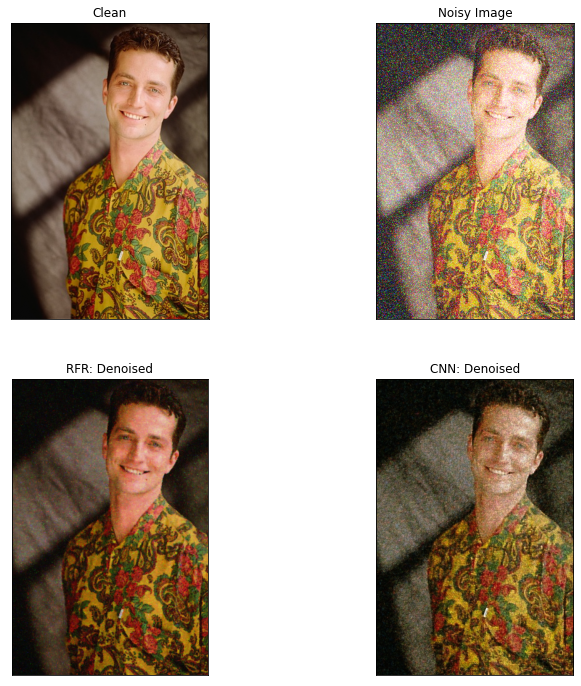

In [38]:
fig = plt.figure(figsize=(12, 12))
index = 6

ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(test_images[index])
ax.set_title('Clean')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(test_degraded_images[index])
ax.set_title('Noisy Image')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 3)
# RFR_cleaned3 = clean_img_RFR(index, w_RFR)
imgplot = plt.imshow(exposure.adjust_gamma(RFR_cleaned3, 1.6))
ax.set_title('RFR: Denoised')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(2, 2, 4)
# CNN_cleaned3 = clean_img_CNN(index, w_CNN)
imgplot = plt.imshow(exposure.adjust_gamma(CNN_cleaned3, 1.2))
ax.set_title('CNN: Denoised')
ax.set_xticks([])
ax.set_yticks([])

## Report

### 1. Surprising Observations

1. Increasing window size beyond a value gave diminishing returns.
2. RFR performed much better than CNN (relatively)
3. Observed dark patches in corrected images which contained salt-n-pepper noise  

### 2. Some thoughts on the observations

1. I believe, as stated before, that wider patches have higher variance of intensity values which make it harder for the model to predict the central pixel.
2. For RFR, I have used three models for each chanel where as CNNs predict all the three intensities at once. Also, the CNN is very shallow and simple and the parameters for each layers were experimented over a small range. Other than this, both random forests and CNNs can model non-linearities in the data.
3. Both the models perform poorly in modelling the s&p noise. This may be due to the simultaneous training across different noise models. This might force the ML engine to minimize the overall error by learning simpler noise-models such as gaussian, poisson, etc. rather than learning the s&p distribution.

### 3. Resources and Acknowledgement

1. [Tensorflow Doc](https://https://www.tensorflow.org/tutorials/images/cnn)
2. [Sci-Kit Learn Doc](https://https://scikit-learn.org/stable/index.html)
3. [Matplotlib Image Support](https://https://matplotlib.org/stable/api/image_api.html#module-matplotlib.image)
4. [Sci-kit image doc](https://scikit-image.org/)
5. [Comparison of Random Forests and CNNs](https://dzone.com/articles/3-reasons-to-use-random-forest-over-a-neural-netwo)
6. [Illustrated CNN architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)

### 4. Motivation for further steps
Recent work on super-resolution is based on Residual Networks. These have also been able to reproduce similar levels of brightness and contrast, which are missing in the work presented for this assignment.